Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

ModuleNotFoundError: No module named 'seaborn'

Load Data & Preprocessing

- `ES1 Index` : S&P 500 Index Futures
- `NQ1 Index` : Nasdaq 100 Index Futures

- `PX_OPEN` : Open
- `PX_HIGH` : High
- `PX_LOW` : Low
- `PX_LAST` : Close

In [2]:
# Price Data
df = pd.read_pickle('ev_df.pkl')

# Tickers
tickers = df.columns.get_level_values(0).unique()

# Close Price
df_close = df.xs('PX_LAST', level=1, axis=1)

# 1-Day Returns
rets = df_close.pct_change().dropna()

# Tick Size
tick_size = 0.25

# Base Notional for Equity Mean Reversion Strategy
total_notional = 1e9
underlying_notional = total_notional / 2

# 1-tick Slippage Cost as Percentage of Close Price
cost = pd.DataFrame((1/df_close).values * tick_size, index=df_close.index, columns=df_close.columns)

Strategy Backtesting

In [3]:
param1 = 10
param2 = 1.0
param3 = 0.5

weights_df = pd.DataFrame(index=df.index, columns=tickers)

for ticker in tickers:
    df_ = df[ticker]

    position = 0

    df_['HL_avg'] = df_['PX_HIGH'].rolling(window=param1).mean() - df_['PX_LOW'].rolling(window=param1).mean()
    df_['Band'] = df_['PX_LAST'].rolling(window=param1).mean() - (df_['HL_avg'] * param2)
    df_['IBS'] = ((df_['PX_LAST'] - df_['PX_LOW']) / (df_['PX_HIGH'] - df_['PX_LOW']))

    df_['Position'] = np.nan

    for i in np.arange(len(df_.index)):
        if i >= param1:
            if (df_['PX_LAST'][i] <= df_['Band'][i]) and (df_['IBS'][i] <= param3):

                position += 1
                df_['Position'][i] = position

            elif (position > 0) and (df_['PX_LAST'][i] >= df_['PX_LAST'][i-1]):

                position = 0
                df_['Position'][i] = position

            else:
                df_['Position'][i] = position

    weights_df[ticker] = df_['Position']

In [4]:
# Underlying Asset Notional
asset_notional = weights_df * underlying_notional

# Total Notional
port_notional = np.abs(asset_notional).sum(axis=1)

# Underlying Asset P&L
asset_pnl = asset_notional.shift() * rets - np.abs(asset_notional.diff()) * cost

# Total P&L
port_pnl = asset_pnl.sum(axis=1)

# S&P 500 Index Daily Return
es_ret = df[('ES1 Index', 'PX_LAST')].pct_change()

Position

Text(0, 0.5, 'KRW 100mio')

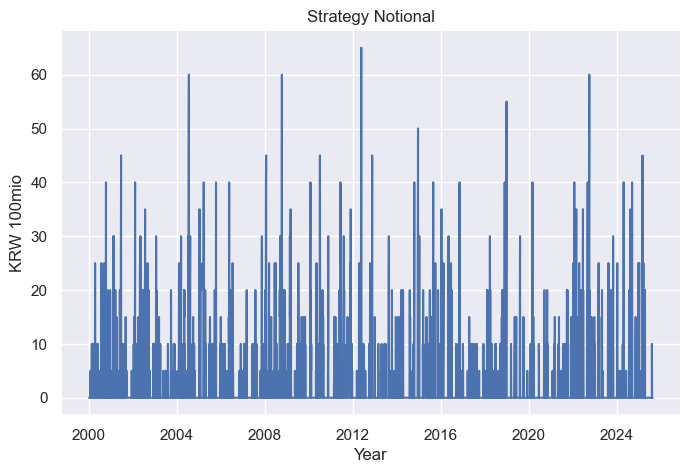

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(port_notional/1e8)
plt.title('Strategy Notional')
plt.xlabel('Year')
plt.ylabel('KRW 100mio')

Realized P&L vs. MtM P&L

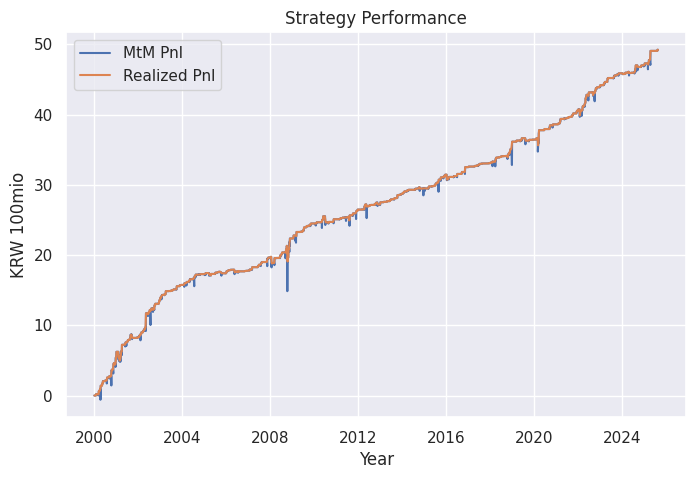

In [22]:
temp_df = pd.concat([port_pnl.cumsum(), ev_weight], axis=1, join='inner')
temp_df.columns = ['cum_pnl', 'pos']

plt.figure(figsize=(8, 5))
plt.plot((port_pnl/1e8).cumsum(), label='MtM Pnl')
plt.plot((temp_df[temp_df['pos'].shift() == 0]['cum_pnl']/1e8), label='Realized Pnl')
plt.ylabel('KRW 100mio')
plt.xlabel('Year')
plt.title('Strategy Performance')
plt.legend()

Save Result

- `es_ret` : S&P 500 Index Daily Return
- `port_pnl` : Equity Mean Reversion Strategy P&L
- `port_notional` : Equity Mean Reversion Strategy Notional

In [6]:
ev_res_df = pd.concat([es_ret, port_pnl, port_notional], axis=1, join='outer')
ev_res_df.columns = ['es_ret', 'pnl', 'notional']
ev_res_df.to_pickle('ev_res_df.pkl')